This is a notebook to explore the trained ANN saved by `create_and_train.py`

In [1]:
try:
    import cPickle as pickle
except:
    import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet, TrainSplit

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# recreate the training and test sets.  I have tested this and confirmed
# that it always reproduces the same arrays

# specify the seed for random number generation so we can get consistent
# shuffling and initialized weights
np.random.seed(6509)

# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
X = pd.read_csv('../parameters_250000.txt', sep=' ')
Y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
Y = Y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)
y_columns = Y.columns.values

X = X.values.astype(np.float32)
Y = Y.values.astype(np.float32)

# Shuffle the dataset (because x parameters are varied in a structured way)
combined = np.concatenate((X, Y), axis=1)
np.random.shuffle(combined)

# Separate the data into training (with included validation) and test sets.
# (Validation set is separated from the training set by nolearn)
test_fraction = 0.2
training = combined[:-int(test_fraction * combined.shape[0]), :]
test = combined[-int(test_fraction * combined.shape[0]):, :]

x_train = training[:, :4]
y_train = training[:, 4:]
x_test = test[:, :4]
y_test = test[:, 4:]

# load the full trained network and related scaling objects
with open('ann_objects.pkl', 'rb') as pkl:
    net_objs = pickle.load(pkl)
net = net_objs[0]
x_scaler = net_objs[1]
y_scaler = net_objs[2]

# make y_scaler for the updated files
y_scaler_updated = preprocessing.StandardScaler().fit(y_train)
y_train_updated = y_scaler_updated.transform(y_train)
y_test_updated = y_scaler_updated.transform(y_test)

# Standardize the input parameters to have zero mean and unit variance
# x_scaler.transform() can be used later to transform any new data
# x_scaler.inverse_transform() can be used to get the original data back
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

# Scale the output parameters to lie between 0 and 1
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

# this class needs to be defined to load the pickles
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0 
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [3]:
output_col_files = !ls ann_objects-*
# dictionary of nets for each output measure
net_objs = {}
for filename in output_col_files:
    output_col = int(filename.split('-')[1])
    with open(filename, 'rb') as pkl:
        net_objs[output_col] = pickle.load(pkl)[0]
        
# load the updated files.  Each of these networks takes about 1 hour to train
updated_output_col_files = !ls updated_ann-*

updated_net_objs = {}
for filename in updated_output_col_files:
    output_col = int(filename.split('-')[1])
    with open(filename, 'rb') as pkl:
        updated_net_objs[output_col] = pickle.load(pkl)[0]
        
# This was a test of the updated script, but with only one hidden layer
test_net_objs = {}
with open('test_updated_ann-2-heavytars.pkl', 'rb') as test:
    test_net_objs[2] = pickle.load(test)[0]

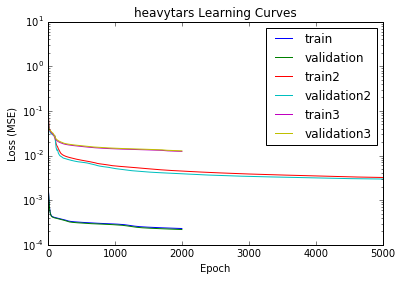

In [4]:
index = 2
title = y_columns[index]
net = net_objs[index]
net_updated = updated_net_objs[index]
net_test = test_net_objs[index]

# Plot the learning curves
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
train_loss2 = np.array([i["train_loss"] for i in net_updated.train_history_])
valid_loss2 = np.array([i["valid_loss"] for i in net_updated.train_history_])
train_loss3 = np.array([i["train_loss"] for i in net_test.train_history_])
valid_loss3 = np.array([i["valid_loss"] for i in net_test.train_history_])

plt.figure(0)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.plot(train_loss2, label='train2')
plt.plot(valid_loss2, label='validation2')
plt.plot(train_loss3, label='train3')
plt.plot(valid_loss3, label='validation3')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.title('%s Learning Curves' % title)

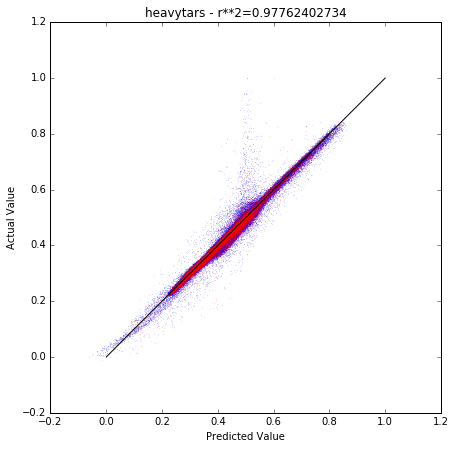

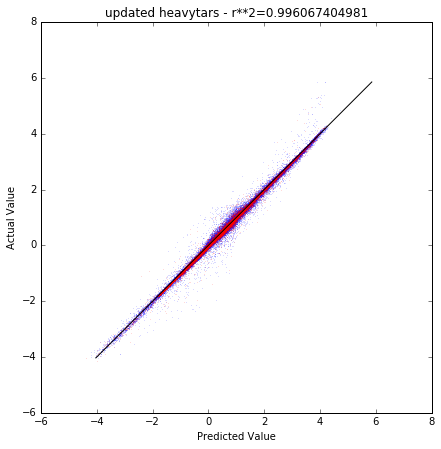

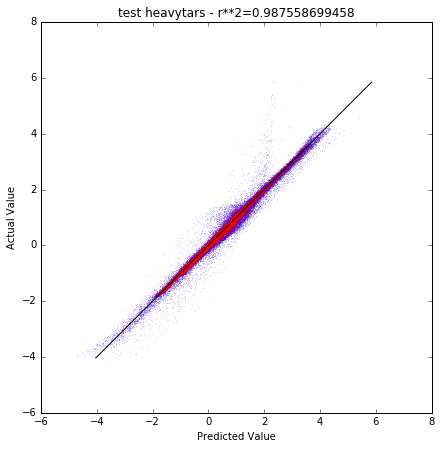

In [21]:
def single_pplot(y_predictions, y_predictions_test, output_col, title,
                 updated=False, ub=None):
    """
    Make a parity plot for the training (blue) and test (red) set predictions
    of a specific output measure.
    
    Parameters
    ----------
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    title              : string
                         The name of the output measure being plotted
    ub                 : int
                         The number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    if ub is None:
        ub = y_predictions.shape[0]
        
    plt.figure(figsize=(7,7))
    # Parity plot of the training data
    if updated == False:
        plt.scatter(y_predictions[:ub], y_train[:ub, output_col],
                    s=0.1, alpha=0.16, c='b', marker='x', label='train')
        plt.plot([0, 1], [0, 1], c='black')
        plt.scatter(y_predictions_test[:ub], y_test[:ub, output_col],
                    s=0.1, alpha=0.16, c='r', marker='x', label='test')
        plt.title('%s - r**2=%s' % (title,
                                    r2_score(y_train[:, output_col],
                                             y_predictions[:])))
    elif updated == True:
        plt.scatter(y_predictions[:ub], y_train_updated[:ub, output_col],
                    s=0.1, alpha=0.16, c='b', marker='x', label='train')
        plt.plot([np.min(y_train_updated[:ub, output_col]),
                 np.max(y_train_updated[:ub, output_col])], 
                 [np.min(y_train_updated[:ub, output_col]),
                 np.max(y_train_updated[:ub, output_col])], c='black')
        plt.scatter(y_predictions_test[:ub], y_test_updated[:ub, output_col],
                    s=0.1, alpha=0.16, c='r', marker='x', label='test')
        plt.title('updated %s - r**2=%s' % (title,
                                    r2_score(y_train_updated[:, output_col],
                                             y_predictions[:])))
    else:
        plt.scatter(y_predictions[:ub], y_train_updated[:ub, output_col],
                    s=0.1, alpha=0.16, c='b', marker='x', label='train')
        plt.plot([np.min(y_train_updated[:ub, output_col]),
                 np.max(y_train_updated[:ub, output_col])], 
                 [np.min(y_train_updated[:ub, output_col]),
                 np.max(y_train_updated[:ub, output_col])], c='black')
        plt.scatter(y_predictions_test[:ub], y_test_updated[:ub, output_col],
                    s=0.1, alpha=0.16, c='r', marker='x', label='test')
        plt.title('test %s - r**2=%s' % (title,
                                    r2_score(y_train_updated[:, output_col],
                                             y_predictions[:])))
        
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    
    return None

# set the index of the output column you want here
index = 2
title = y_columns[index]
net = net_objs[index]
net2 = updated_net_objs[index]
net3 = test_net_objs[index]
y_predictions = net.predict(x_train)
y_predictions_test = net.predict(x_test)
single_pplot(y_predictions, y_predictions_test, index, title)
y_predictions2 = net2.predict(x_train)
y_predictions_test2 = net2.predict(x_test)
single_pplot(y_predictions2, y_predictions_test2, index, title, updated=True)
y_predictions3 = net3.predict(x_train)
y_predictions_test3 = net3.predict(x_test)
single_pplot(y_predictions3, y_predictions_test3, index, title, updated='test')

# from this we can see that including the second hidden layer makes a difference


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


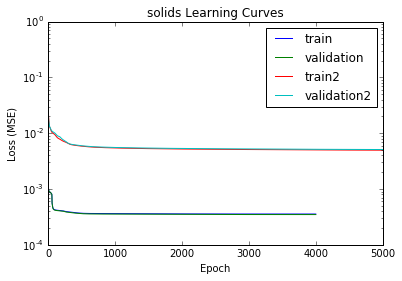

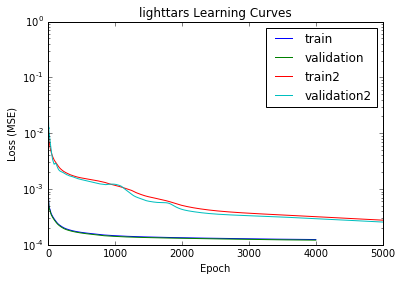

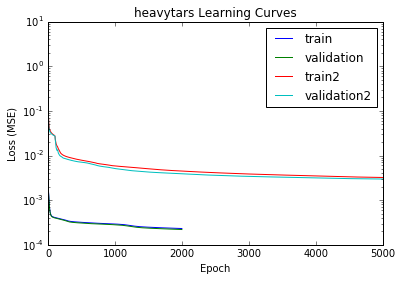

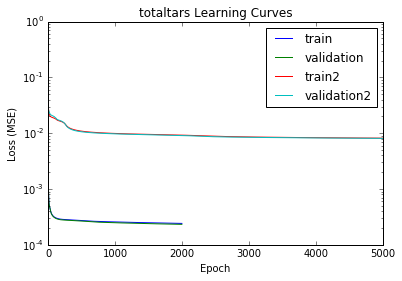

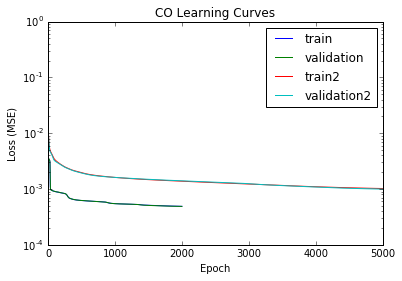

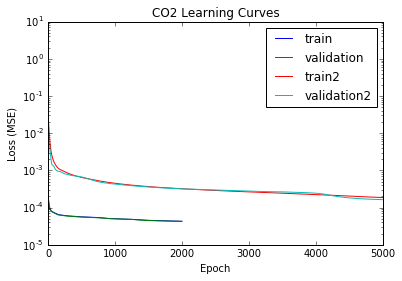

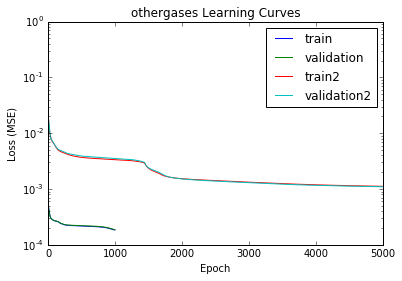

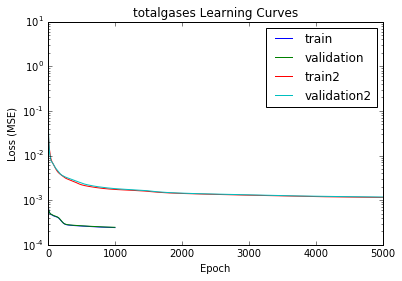

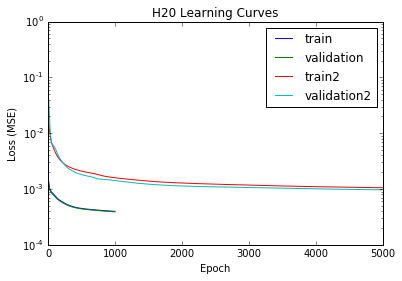

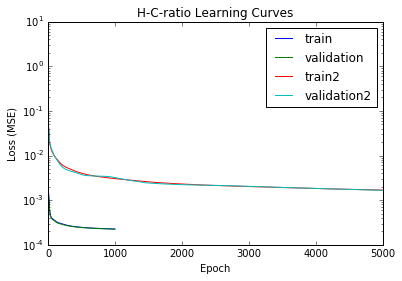

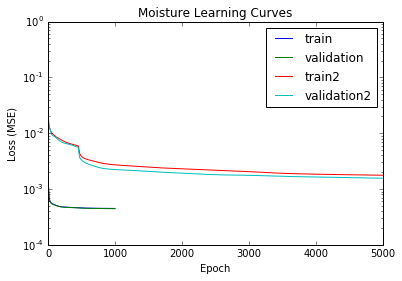

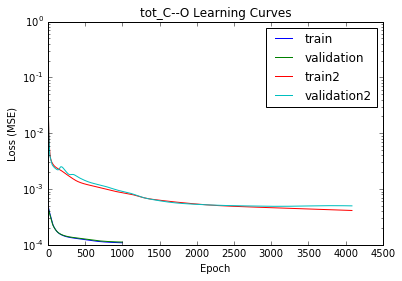

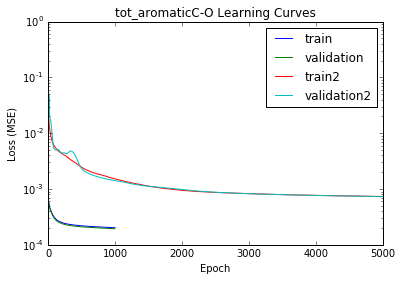

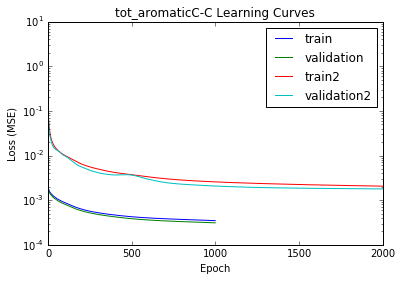

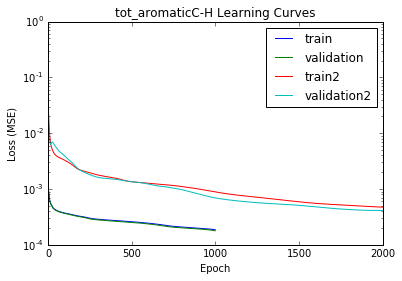

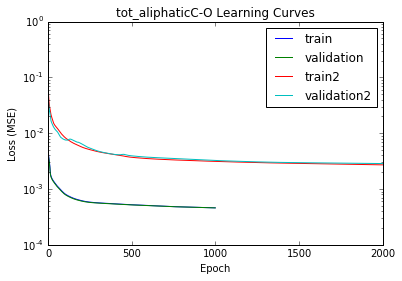

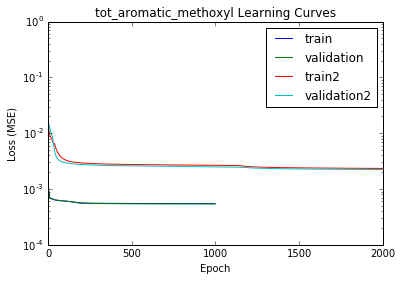

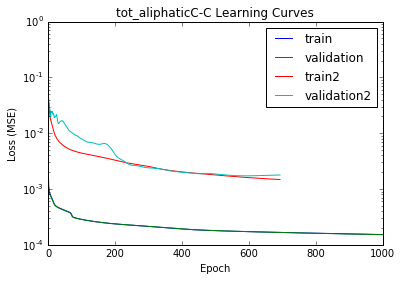

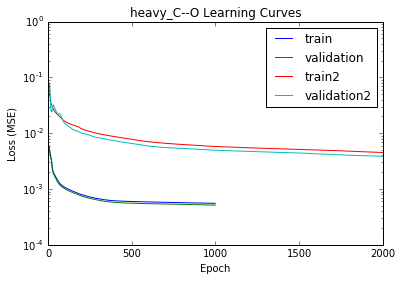

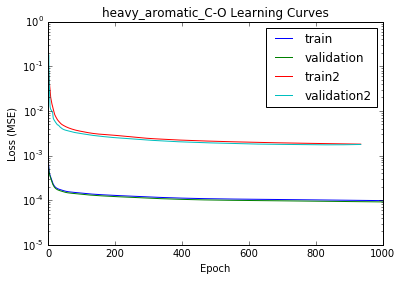

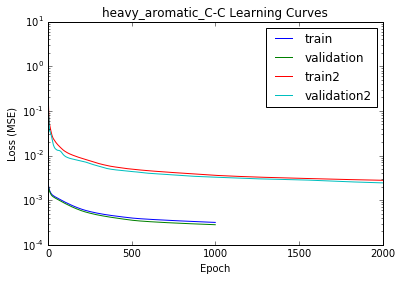

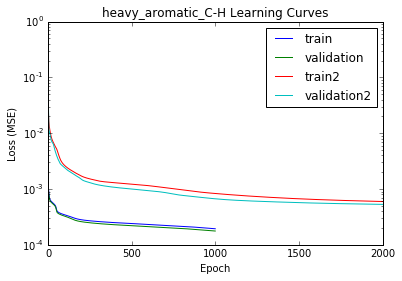

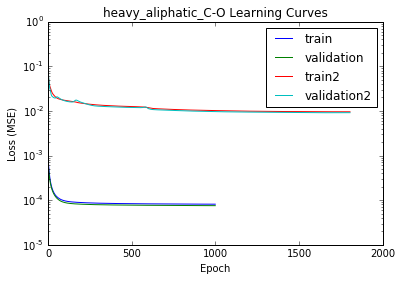

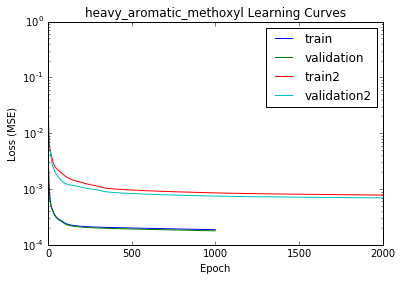

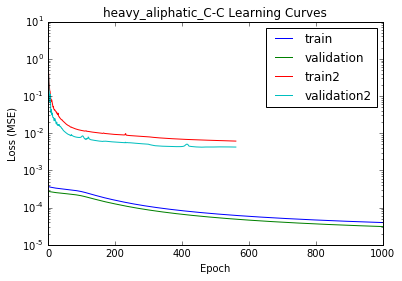

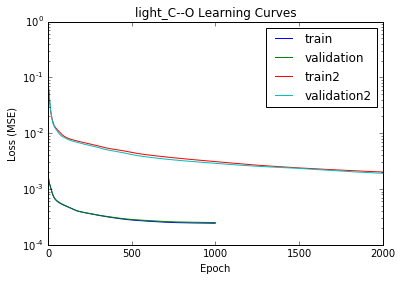

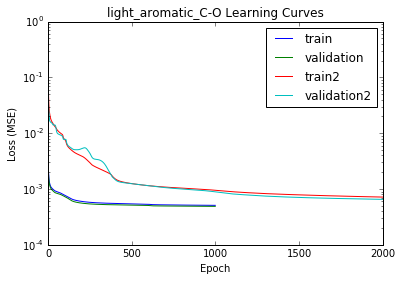

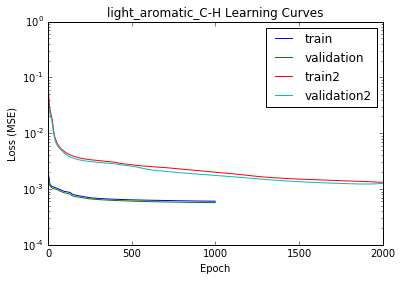

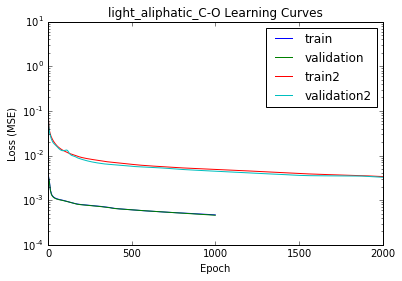

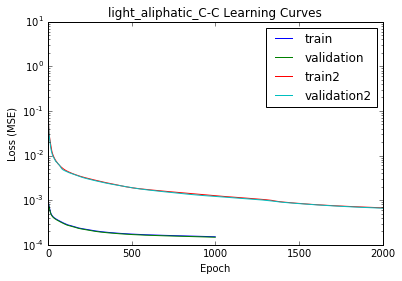

In [5]:
# Plot learning curves for all output measures
for key in net_objs:
    title = y_columns[key]
    net = net_objs[key]
    net_updated = updated_net_objs[key]

    # Plot the learning curves
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    train_loss2 = np.array([i["train_loss"] 
                            for i in net_updated.train_history_])
    valid_loss2 = np.array([i["valid_loss"] 
                            for i in net_updated.train_history_])

    plt.figure(key)
    plt.plot(train_loss, label='train')
    plt.plot(valid_loss, label='validation')
    plt.plot(train_loss2, label='train2')
    plt.plot(valid_loss2, label='validation2')
    plt.legend(loc=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.yscale('log')
    plt.title('%s Learning Curves' % title)


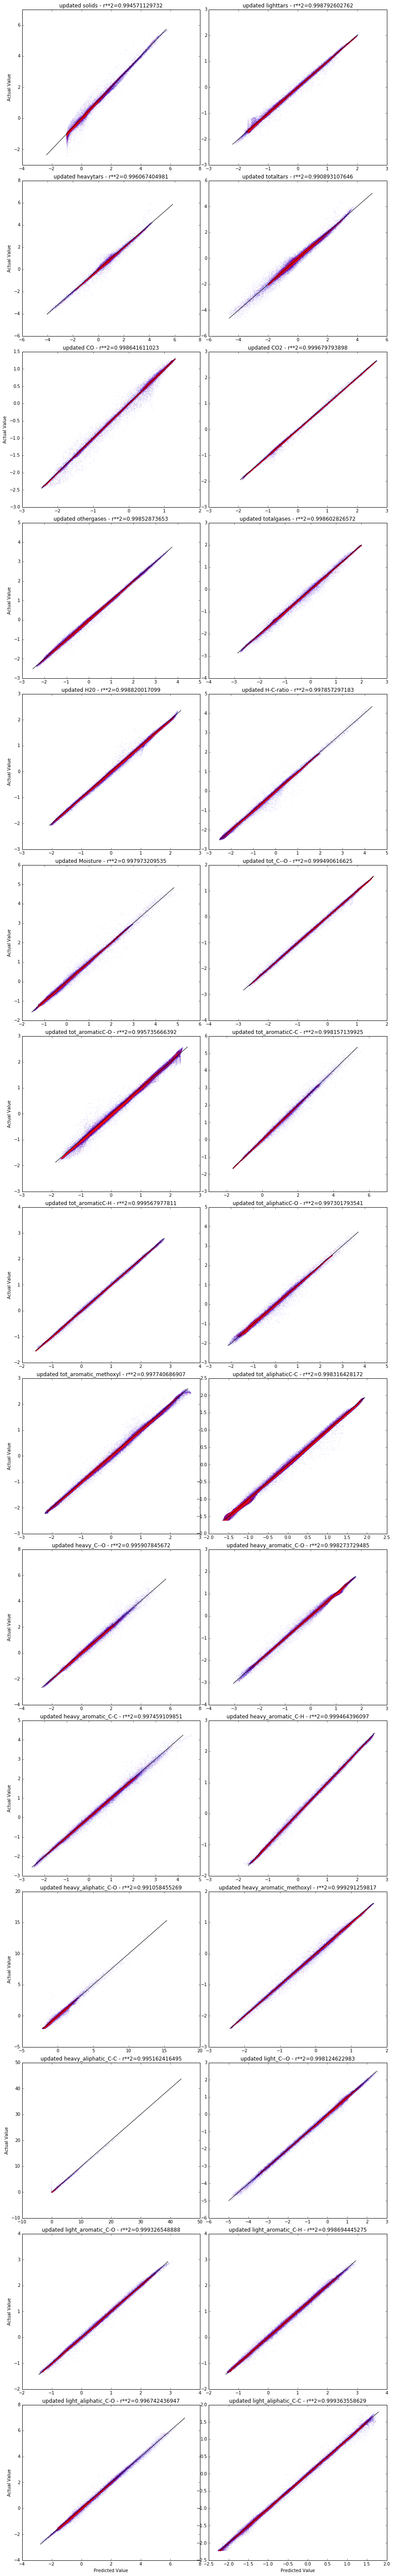

In [9]:
def pplot_one_output_updated(y_predictions, y_predictions_test, output_col,
                             title, ub=None):
    """
    Make a parity plot for the training (blue) and test (red) set predictions
    of a specific output measure.
    
    Parameters
    ----------
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    title              : string
                         The name of the output measure being plotted
    ub                 : int
                         The number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    if ub is None:
        ub = y_predictions.shape[0]

    # Parity plot of the training data
    ax[output_col].scatter(y_predictions[:ub].flatten(),
                           y_train_updated[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='b', marker='x', label='train')
    ax[output_col].plot([np.min(y_train_updated[:ub, output_col]),
                         np.max(y_train_updated[:ub, output_col])],
                        [np.min(y_train_updated[:ub, output_col]),
                         np.max(y_train_updated[:ub, output_col])], c='black')
    ax[output_col].scatter(y_predictions_test[:ub].flatten(),
                           y_test_updated[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='r', marker='x', label='test')
    ax[output_col].set_title('updated %s - r**2=%s' % (title,
                                    r2_score(y_train_updated[:, output_col],
                                    y_predictions[:])))

    return None


output_list = updated_net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=False,
                     sharey=False, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

for key in updated_net_objs:
    title = y_columns[key]
    net = updated_net_objs[key]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    pplot_one_output_updated(y_predictions, y_predictions_test, key, title)

ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

In [ ]:
r_squared = {}
r_squared_updated = {}
difference = {}
for key in net_objs:
    net = net_objs[key]
    net_updated = updated_net_objs[key]
    title = y_columns[key]
    y_predictions = net.predict(x_train)
    y_predictions_updated = net_updated.predict(x_train)
    r_squared[title] = r2_score(y_train[:, key], y_predictions[:])
    r_squared_updated[title] = r2_score(y_train_updated[:, key],
                                        y_predictions_updated[:])
    difference[title] = r_squared_updated[title] - r_squared[title]

In [15]:
r_squared_updated

{'CO': 0.99864161102337823,
 'CO2': 0.99967979389809447,
 'H-C-ratio': 0.99785729718273464,
 'H20': 0.99882001709948964,
 'Moisture': 0.99797320953545698,
 'heavy_C--O': 0.99590784567153678,
 'heavy_aliphatic_C-C': 0.99516241649486947,
 'heavy_aliphatic_C-O': 0.99105845526853986,
 'heavy_aromatic_C-C': 0.9974591098514789,
 'heavy_aromatic_C-H': 0.99946439609736148,
 'heavy_aromatic_C-O': 0.998273729484637,
 'heavy_aromatic_methoxyl': 0.99929125981687472,
 'heavytars': 0.99606740498060864,
 'light_C--O': 0.99812462298274007,
 'light_aliphatic_C-C': 0.99936355862887349,
 'light_aliphatic_C-O': 0.9967424369470087,
 'light_aromatic_C-H': 0.99869444527450102,
 'light_aromatic_C-O': 0.9993265488884534,
 'lighttars': 0.99879260276216497,
 'othergases': 0.99852873653016516,
 'solids': 0.99457112973231432,
 'tot_C--O': 0.99949061662479499,
 'tot_aliphaticC-C': 0.99831642817245991,
 'tot_aliphaticC-O': 0.9973017935410623,
 'tot_aromaticC-C': 0.99815713992480359,
 'tot_aromaticC-H': 0.99956797781

In [14]:
keylist = r_squared.keys()
keylist.sort()
print 'Difference in R**2 values\n'
for x in keylist:
    print '%s:%s' % ('{: <28}'.format(x),
                     '{: >10}'.format(round(difference[x], 4)))

Difference in R**2 values

CO                          :    0.0055
CO2                         :    0.0006
H-C-ratio                   :    0.0085
H20                         :    0.0066
Moisture                    :    0.0164
heavy_C--O                  :    0.0342
heavy_aliphatic_C-C         :    0.0672
heavy_aliphatic_C-O         :    0.0154
heavy_aromatic_C-C          :    0.0117
heavy_aromatic_C-H          :    0.0029
heavy_aromatic_C-O          :    0.0005
heavy_aromatic_methoxyl     :    0.0023
heavytars                   :    0.0184
light_C--O                  :    0.0118
light_aliphatic_C-C         :    0.0018
light_aliphatic_C-O         :    0.0404
light_aromatic_C-H          :      0.01
light_aromatic_C-O          :    0.0088
lighttars                   :     0.001
othergases                  :    0.0057
solids                      :    0.0176
tot_C--O                    :    0.0016
tot_aliphaticC-C            :    0.0002
tot_aliphaticC-O            :     0.013
tot_aromaticC

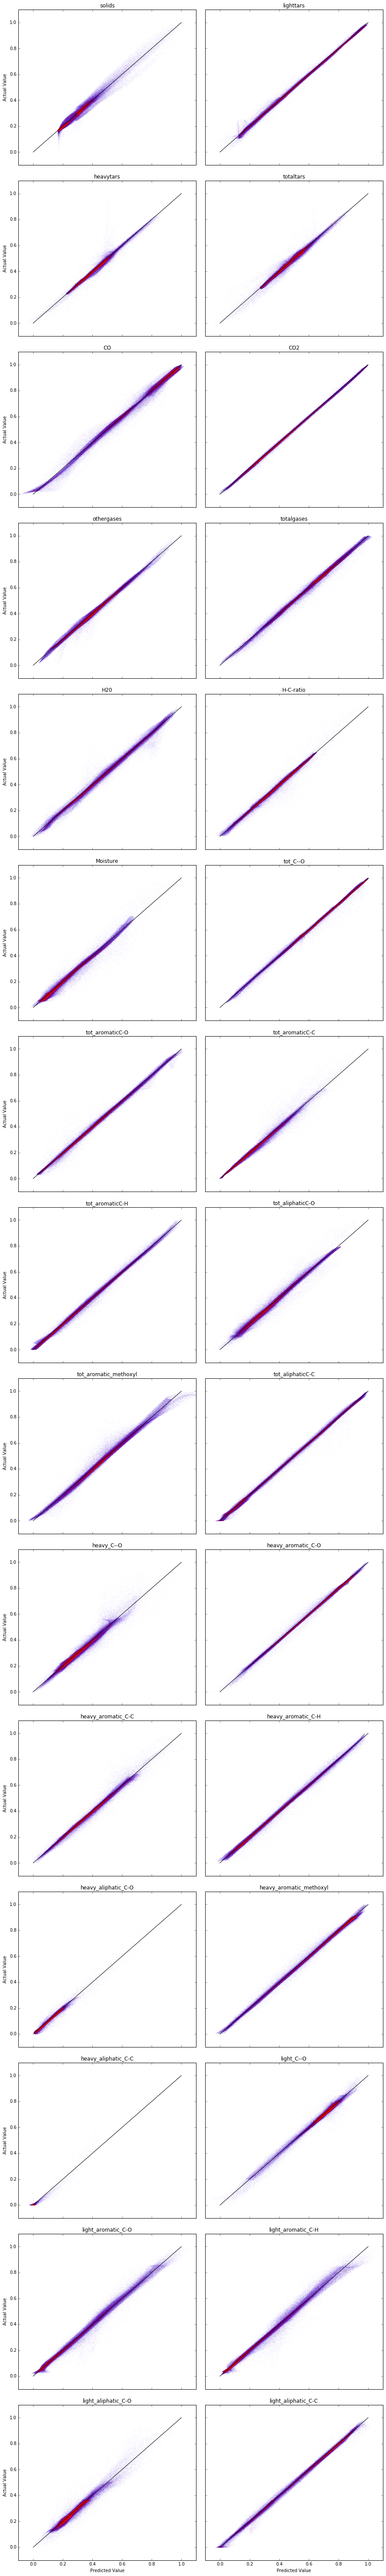

In [11]:
def pplot_one_output(y_predictions, y_predictions_test, output_col, title,
                     ub=None):
    """
    Make a parity plot for the training (blue) and test (red) set predictions
    of a specific output measure.
    
    Parameters
    ----------
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    title              : string
                         The name of the output measure being plotted
    ub                 : int
                         The number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    if ub is None:
        ub = y_predictions.shape[0]

    # Parity plot of the training data
    ax[output_col].scatter(y_predictions[:ub].flatten(),
                           y_train[:ub, output_col].flatten(),
                           s=0.1, alpha=0.05,
                           c='b', marker='x', label='train')
    ax[output_col].plot([0, 1], [0, 1], c='black')
    ax[output_col].scatter(y_predictions_test[:ub].flatten(),
                           y_test[:ub, output_col].flatten(),
                           s=0.1, alpha=0.05,
                           c='r', marker='x', label='test')
    ax[output_col].set_title('%s' % title)
    ax[output_col].set_xlim([-0.1, 1.1]) 
    ax[output_col].set_ylim([-0.1, 1.1])
    
    return None


output_list = net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=True,
                     sharey=True, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

for key in net_objs:
    title = y_columns[key]
    net = net_objs[key]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    pplot_one_output(y_predictions, y_predictions_test, key, title)

ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

In [12]:
r_squared = {}
for key in net_objs:
    net = net_objs[key]
    title = y_columns[key]
    y_predictions = net.predict(x_train)
    r_squared[title] = r2_score(y_train[:, key], y_predictions[:])
r_squared

{'CO': 0.9931549818169555,
 'CO2': 0.99908888412289854,
 'H-C-ratio': 0.98937436609537766,
 'H20': 0.99222651908028614,
 'Moisture': 0.98161438185322558,
 'heavy_C--O': 0.96169319394720032,
 'heavy_aliphatic_C-C': 0.92793016293697483,
 'heavy_aliphatic_C-O': 0.97566368021067218,
 'heavy_aromatic_C-C': 0.98579905607064755,
 'heavy_aromatic_C-H': 0.99654989201181154,
 'heavy_aromatic_C-O': 0.99776653497806722,
 'heavy_aromatic_methoxyl': 0.99697604013818319,
 'heavytars': 0.97762402733985954,
 'light_C--O': 0.98635975047879665,
 'light_aliphatic_C-C': 0.99760078267534069,
 'light_aliphatic_C-O': 0.95630015834295601,
 'light_aromatic_C-H': 0.98873695601630907,
 'light_aromatic_C-O': 0.99049610190610538,
 'lighttars': 0.99776872584397636,
 'othergases': 0.99280111514032288,
 'solids': 0.97692156275424058,
 'tot_C--O': 0.99789811561406894,
 'tot_aliphaticC-C': 0.99808325111053575,
 'tot_aliphaticC-O': 0.9842770704965923,
 'tot_aromaticC-C': 0.98328267733525454,
 'tot_aromaticC-H': 0.9965250

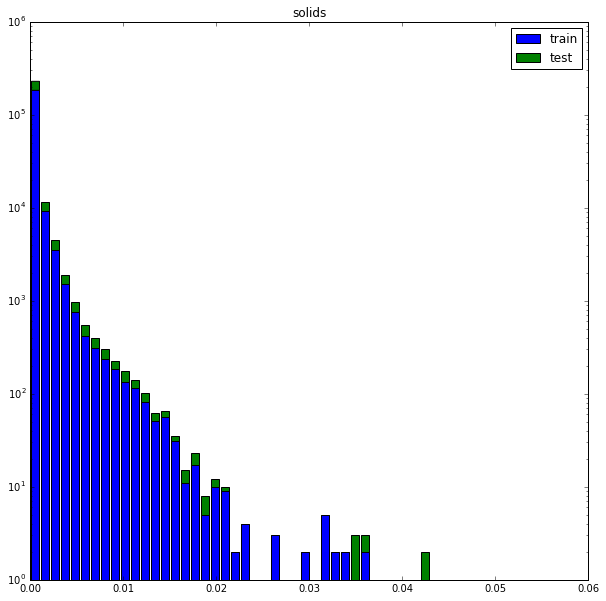

In [14]:
# Make a histogram for a specific output measure
output_col = 0
train_mse = []
net = net_objs[output_col]
y_predictions = net.predict(x_train)
for i, value in enumerate(y_train[:]):
    train_mse.append(mean_squared_error([y_train[i][output_col]],
                                        [y_predictions[i]]))
    
test_mse = []
y_predictions_test = net.predict(x_test)
for i, value in enumerate(y_test[:]):
    test_mse.append(mean_squared_error([y_test[i][output_col]],
                                       [y_predictions_test[i]]))

plt.figure(300, figsize=(10, 10))
plt.hist([train_mse, test_mse], bins=50, stacked=True, label=['train', 'test'],
         log=True)
plt.legend(loc=0)
plt.title('%s' % y_columns[output_col])


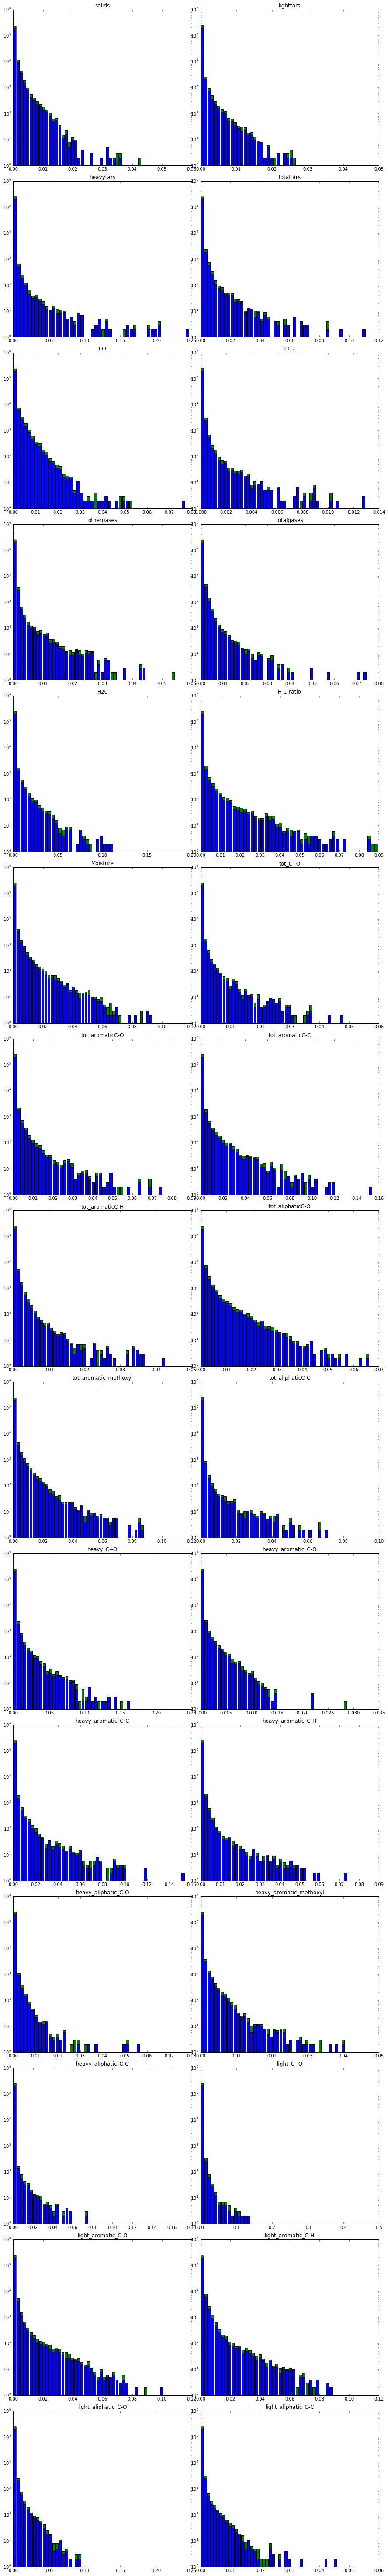

In [15]:
def hplot_one_output(y_train, y_test, y_predictions,
                     y_predictions_test, output_col):
    """
    Make a histogram for the training (blue) and test (green)
    MSEs of a specific output measure.
    
    Parameters
    ----------
    y_train            : numpy ndarray
                         The array with the training set values
    y_test             : numpy ndarray
                         The array with the test set values
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    
    Returns
    -------
    None
    """
    train_mse = []
    for i, value in enumerate(y_train[:]):
        train_mse.append(mean_squared_error([y_train[i][output_col]],
                                            [y_predictions[i]]))

    test_mse = []
    for i, value in enumerate(y_test[:]):
        test_mse.append(mean_squared_error([y_test[i][output_col]],
                                           [y_predictions_test[i]]))

    ax[output_col].hist([train_mse, test_mse], bins=50, stacked=True,
                        label=['train', 'test'], log=True)
    ax[output_col].set_title('%s' % y_columns[output_col])


output_list = net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2,
                     figsize=(15, 3.5*len(output_list)))

ax = ax.ravel()
for key in net_objs:
    net = net_objs[key]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    hplot_one_output(y_train, y_test, y_predictions, y_predictions_test, key)
f.subplots_adjust(hspace=0.1, wspace=0.05)
    